In [2]:
ver=8       # Name the version of revision

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Concatenate, Resizing, concatenate
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split

In [ ]:
# In case that the data are in two separated folders, named Adipo and Osteo, 
# and the masks from last step are both in a folder named as mask1_rev.

L2= shuffle(glob.glob('**/mask1_rev/**_msk.png'))

L1=[]
for l in L2:
    # L1.append('data/' + l.split('/')[-1].split('_msk.png')[0] + '.tif')
    L1.append(l.split('/')[0] + '/data/' + l.split('/')[-1].split('_msk.png')[0] + '.tif')

print(len(L2))
print(len(L2))

In [ ]:
l.split('/')[0]

In [21]:
df = pd.DataFrame({
    'filename': L1,
    'msk': L2
})

df = shuffle(df)
df.head(10)

,filename,msk
1700,Osteo/data/Osteo_2_2_Tv104.tif,Osteo/mask2_rev/Osteo_2_2_Tv104_msk.png
498,Osteo/data/Osteo_1_5_Tv63.tif,Osteo/mask2_rev/Osteo_1_5_Tv63_msk.png
369,Adipo/data/Adipo_2_8_Tv119.tif,Adipo/mask2_rev/Adipo_2_8_Tv119_msk.png
1440,Adipo/data/Adipo_2_13_Tv56.tif,Adipo/mask2_rev/Adipo_2_13_Tv56_msk.png
1507,Adipo/data/Adipo_2_20_Tv109.tif,Adipo/mask2_rev/Adipo_2_20_Tv109_msk.png
991,Adipo/data/Adipo_0.5_4_Tv47.tif,Adipo/mask2_rev/Adipo_0.5_4_Tv47_msk.png
282,Adipo/data/Adipo_2_1_Tv119.tif,Adipo/mask2_rev/Adipo_2_1_Tv119_msk.png
1446,Adipo/data/Adipo_0.5_14_Tv53.tif,Adipo/mask2_rev/Adipo_0.5_14_Tv53_msk.png
1737,Adipo/data/Adipo_0.5_15_Tv57.tif,Adipo/mask2_rev/Adipo_0.5_15_Tv57_msk.png
1202,Adipo/data/Adipo_1_3_Tv78.tif,Adipo/mask2_rev/Adipo_1_3_Tv78_msk.png


In [24]:
INPUT_WIDTH = 512
INPUT_HEIGHT = 688
INPUT_SIZE = (INPUT_WIDTH, INPUT_HEIGHT)

IMAGE_CHANNELS=3

In [25]:
drp_rate= 0.2
l2_rt= 5e-2
start_neurons = 32
input = Input(shape= (INPUT_WIDTH, INPUT_HEIGHT, IMAGE_CHANNELS))

conv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(input)
conv1 = Dropout(drp_rate)(conv1)
# conv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(conv1)
conv1= BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(pool1)
conv2 = Dropout(drp_rate)(conv2)
# conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(conv2)
conv2= BatchNormalization()(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
# convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(convm)
convm = BatchNormalization()(convm)


# deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
deconv2 = UpSampling2D((2,2))(convm)
uconv2 = concatenate([deconv2, conv2])
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(uconv2)
uconv2 = Dropout(drp_rate)(uconv2)
# uconv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(uconv2)
uconv2= BatchNormalization()(uconv2)

# deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
deconv1 = UpSampling2D((2,2))(uconv2)
uconv1 = concatenate([deconv1, conv1])
uconv1 = Conv2D(start_neurons//4, (3, 3), activation='relu', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(uconv1)
uconv1 = Dropout(drp_rate)(uconv1)
uconv1= BatchNormalization()(uconv1)

x_out = Conv2D(1, (3,3), activation='sigmoid', padding='same', kernel_regularizer = regularizers.l2(l2_rt))(uconv1)
model = Model(inputs=input, outputs=x_out)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 688, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 512, 688, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_4 (Dropout)            (None, 512, 688, 32  0           ['conv2d_6[0][0]']               
                                )                                                           

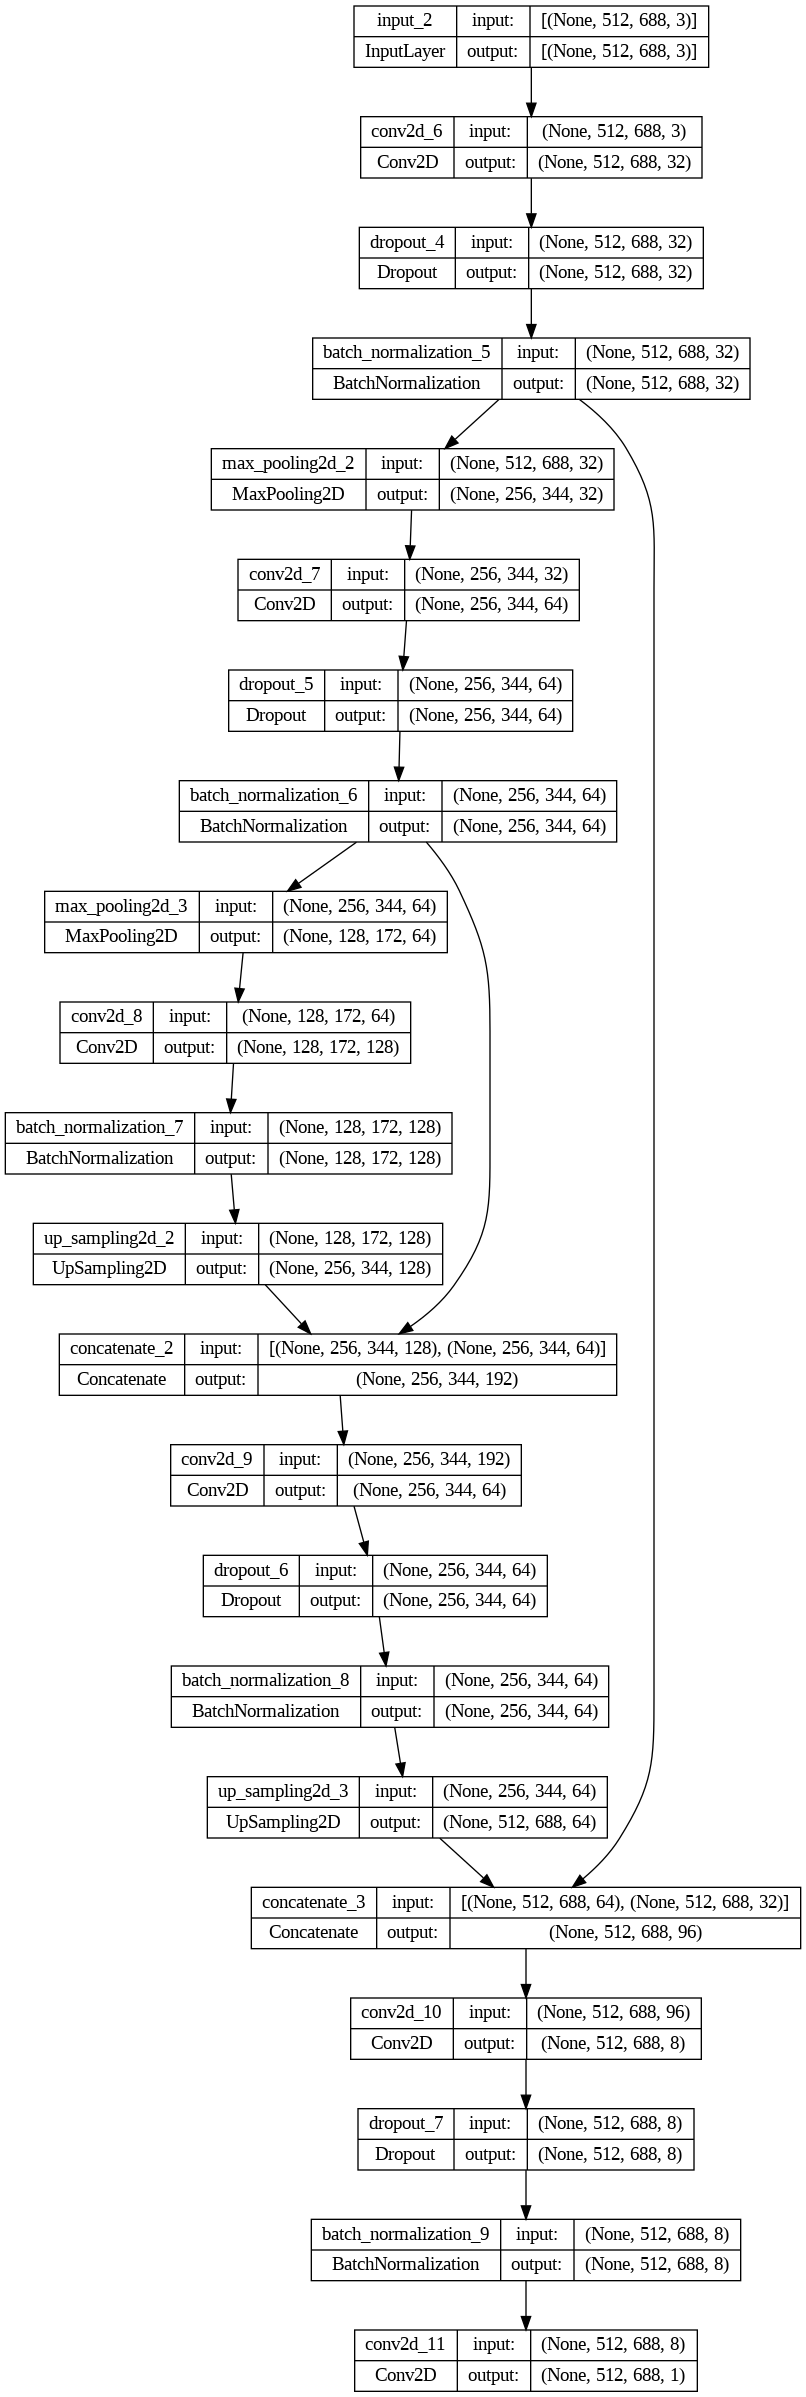

In [26]:
print (model.summary())
plot_model (model, show_shapes=True)

In [13]:
def custom_augmentation(np_tensor):
 
    def random_contrast(np_tensor):
        return tf.image.random_contrast(np_tensor, 0.5, 1)
    
    def random_hue(np_tensor):
        return tf.image.random_hue(np_tensor, 0.1)
    
    def random_saturation(np_tensor):
        return tf.image.random_saturation(np_tensor, 0.5, 1)
    
    augmnted_tensor = random_contrast(np_tensor)
    augmnted_tensor = random_hue(augmnted_tensor)
    augmnted_tensor = random_saturation(augmnted_tensor)
    return np.array(augmnted_tensor)

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.4, random_state=100)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

IMAGE_SIZE=list(x_out.shape [1:3])

total_train= len(train_df)
total_val= len(validate_df)

batch_size= 4
seed = 100 # Important

def prep (image):
    return 1-image
X_train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8,1.0], \
    preprocessing_function=custom_augmentation
)

train_datagen = ImageDataGenerator(
    rescale=1./255, 
)


X_train_generator = X_train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    # y_col='msk',
    target_size= INPUT_SIZE,
    class_mode=None,
    batch_size=batch_size,
    seed=seed
)

y_train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='msk',
    target_size= IMAGE_SIZE,
    color_mode="grayscale",
    class_mode=None,
    batch_size=batch_size,
    seed=seed
)

X_v_generator = train_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    # y_col='msk',
    target_size= INPUT_SIZE,
    class_mode=None,
    batch_size=batch_size,
    seed=seed)

y_v_generator = train_datagen.flow_from_dataframe(
    validate_df, 
    x_col='msk',
    target_size=  IMAGE_SIZE,
    color_mode="grayscale",
    class_mode=None,
    batch_size=batch_size,
    seed=seed
)

train_generator = zip(X_train_generator, y_train_generator)
validation_generator = zip(X_v_generator, y_v_generator)

In [ ]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    #   y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

In [ ]:
checkpoint_path= f'Arash/checkpoint{ver}'
# model.load_weights(checkpoint_path)

In [ ]:
lr= 6e-6

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9 , min_delta=0.05, patience=2, min_lr=1e-6)
rmsp= RMSprop(learning_rate=lr)
# sgd= SGD(learning_rate=lr)

model.compile(optimizer= rmsp, loss=dice_loss, metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', min_delta=0.004, patience=5)
checkpoint_filepath = checkpoint_path
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq="epoch")

history = model.fit (train_generator, epochs=60, verbose=1, 
           steps_per_epoch= 5*total_train//batch_size, 
           validation_data=validation_generator,
           validation_steps=total_val//batch_size, 
           callbacks=[early_stop, model_checkpoint_callback, reduce_lr],
           )

In [ ]:
model.save (f'CNN2_v{ver}.model')
np.save(f'hist{ver}.npy', history.history['loss'])